In [72]:
import numpyro
import numpy as np 
from jax import random
import arviz as az
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt

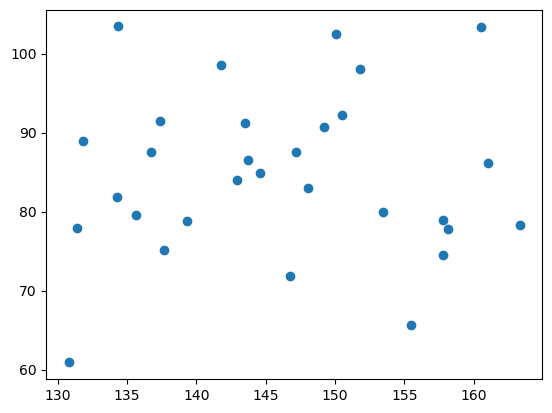

In [76]:
# Using ChatGPT to generate "fake" data for short heavy people

# Set the number of people
n_people = 30

# Generate true heights and weights

heights_true = np.random.normal(loc=145, scale=7, size=n_people)  

weights_true = np.random.normal(loc=85, scale=5, size=n_people)   

# Add uncertainty to the observed heights and weights
heights_observed = heights_true + np.random.randn(n_people) * 10  
weights_observed = weights_true + np.random.randn(n_people) * 10  

# Display the data
data = np.vstack([heights_observed, weights_observed])
plt.scatter(heights_observed, weights_observed)




In [77]:
def model(heights_obs, weights_obs=None):
    # Hyperpriors for group-level parameters
    mu_height = numpyro.sample("mu_height", dist.Normal(145, 40))  # Group mean for height
    sigma_height = numpyro.sample("sigma_height", dist.HalfNormal(20))  # Group std for height

    mu_weight = numpyro.sample("mu_weight", dist.Normal(85, 40))  # Group mean for weight
    sigma_weight = numpyro.sample("sigma_weight", dist.HalfNormal(20))  # Group std for weight

    # Individual-level true heights and weights
    with numpyro.plate('plate_i', n_people):
        true_heights_ = numpyro.sample("true_heights_", dist.Normal(mu_height, sigma_height).expand([n_people]))
        true_weights_ = numpyro.sample("true_weights_", dist.Normal(mu_weight, sigma_weight).expand([n_people]))
        true_heights =  numpyro.deterministic('true_heights', mu_height + true_heights_)
        true_weights =  numpyro.deterministic('true_weights', mu_weight + true_weights_)

    # Observation noise
    obs_height_noise = numpyro.sample("obs_height_noise", dist.HalfNormal(10))
    obs_weight_noise = numpyro.sample("obs_weight_noise", dist.HalfNormal(10))

    # Likelihood: observed heights and weights with individual noise
    with numpyro.plate('data', n_people):
        numpyro.sample("heights_obs", dist.Normal(true_heights, obs_height_noise), obs=heights_obs)
        numpyro.sample("weights_obs", dist.Normal(true_weights, obs_weight_noise), obs=weights_obs)

In [78]:
rng_key = random.PRNGKey(0)
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=2000)
mcmc.run(rng_key, heights_obs=heights_observed, weights_obs=weights_observed)


sample: 100%|██████████| 4000/4000 [00:08<00:00, 488.00it/s, 63 steps of size 5.31e-02. acc. prob=0.91] 


In [79]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
         mu_height     72.97      0.92     72.97     71.40     74.35    765.81      1.00
         mu_weight     42.33      1.02     42.29     40.59     43.87    942.42      1.00
  obs_height_noise      5.77      3.26      6.03      0.21      9.81     32.70      1.04
  obs_weight_noise      7.27      3.30      7.81      1.66     12.28     36.37      1.02
      sigma_height      7.38      2.80      7.76      2.42     11.35     57.58      1.01
      sigma_weight      6.78      3.67      7.18      0.24     11.28     35.71      1.00
  true_heights_[0]     81.73      6.50     82.80     70.61     90.53     61.41      1.02
  true_heights_[1]     75.52      4.10     75.92     69.32     82.29    413.55      1.00
  true_heights_[2]     64.40      5.88     63.60     56.21     73.96     66.05      1.02
  true_heights_[3]     71.14      3.87     70.90     64.93     77.30    980.40      1.00
  true_heights_[4]  

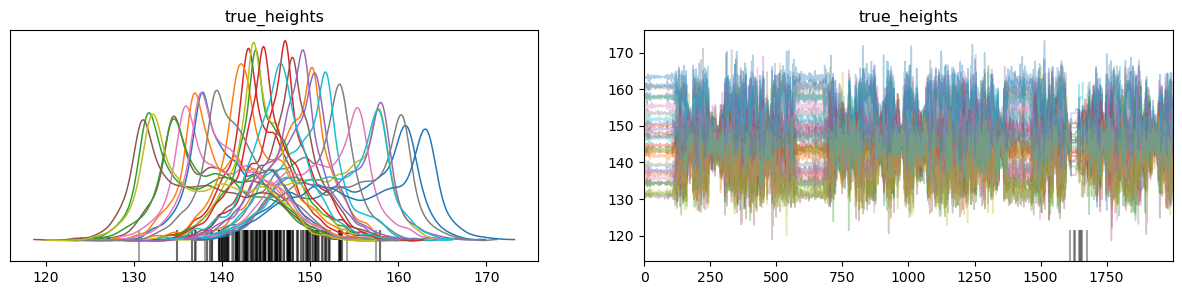

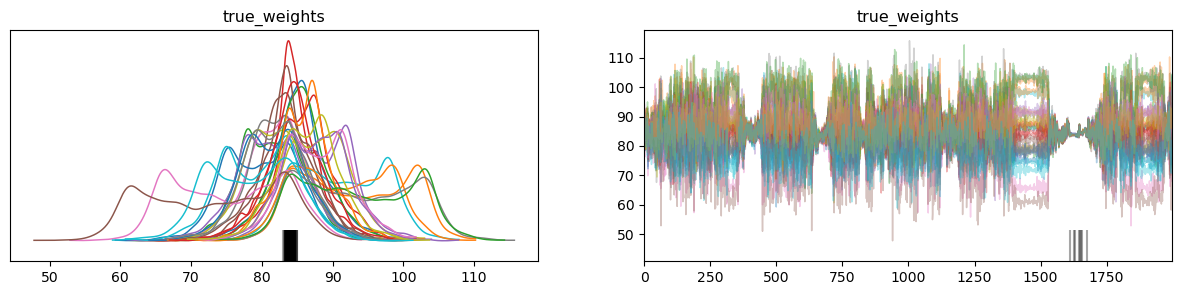

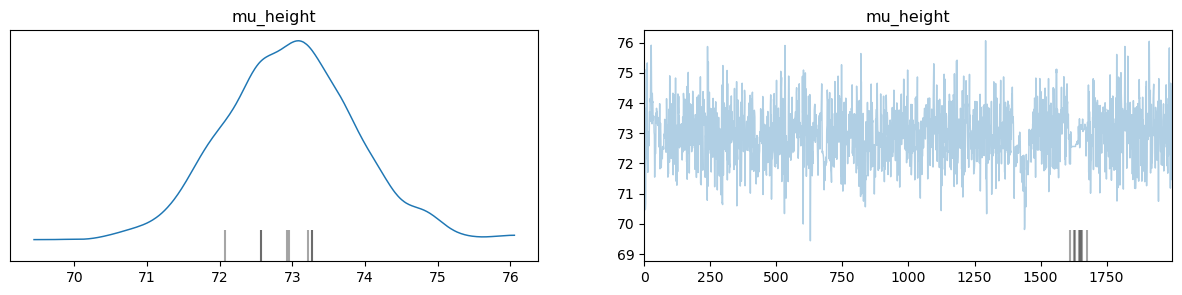

In [80]:
model_output = az.from_numpyro(mcmc)
az.plot_trace(model_output, var_names=['true_heights'], compact=True, figsize=(15, 3));
az.plot_trace(model_output, var_names=['true_weights'], compact=True, figsize=(15, 3));
az.plot_trace(model_output, var_names=['mu_height'], compact=True, figsize=(15, 3));
